## Amazon Dataset
* EDA,Cleaning,Preprocessing on the Reviews "Text" feature. 
#### References
Dataset - https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is neutral and ignored. This is an approximate way of determining the polarity (positivity/negativity) of a review.

#### Loading the data
The dataset is available in two forms
1. .csv file
2. SQLite Database

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
#importing the libraries
import numpy as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import sqlite3 as sq
import pickle as pk

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import shuffle 

In [4]:
from sklearn.manifold import  TSNE

import re
from nltk.corpus import stopwords

import gensim

C:\Users\vipul\Anaconda3\lib\site-packages\gensim\utils.py:862: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [5]:
import nltk
#nltk.download()

In [6]:
#loading the data 
con = sq.connect("database.sqlite")
filter_data =pd.read_sql_query("""
select * from reviews where score !=3
""",con)
con.close()

filter_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


* Shape : (525814,10)

In [7]:
#function to convert the review score into only two categories : positive(score>=3) else negative
def partition(x):
    if x<3:
        return "negative"
    return "positive"

filter_data["Score"]=filter_data["Score"].map(partition)


In [8]:
filter_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### EDA
#### Data Cleaning - Removing the duplicates (Data Deduplication)
Many real world data contain duplicate entries which must be removed otherwise we may get biased results.

In [9]:
#Sorting the data based on productID in ascending order
sort_data=filter_data.sort_values("ProductId")

In [10]:
#Removing the duplicates
final=sort_data.drop_duplicates(subset=['UserId','ProfileName',"Time","Text"])
final.shape

(364173, 10)

**Observe:** We are left with approx 69% of the original data after cleaning which means more than 30% was duplicate data

**Note:** HelpfulnessNumerator must always be less than or equal to HelpfulnessDenominator. Lets remove them also.

In [11]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
final.shape

(364171, 10)

* There were two such entries.

#### Data cleaning is an art, which requires a lot of intuition and common sense which comes by experience.
* Applies for everyone ,including me. so kindly understand the mistakes ;) .  

** Save the cleaned file in a new database .**

In [12]:
conn=sq.connect('final.sqlite')
c=conn.cursor()
final.to_sql("Reviews",conn,if_exists='replace')
conn.close()

### Reviews

In [8]:
#Reading the updated sqlite file
conn=sq.connect('final.sqlite')
final=pd.read_sql_query("""select * from Reviews ;""",conn)

#### TF-IDF

In [15]:
tfidf_vect=TfidfVectorizer()
tfidf=tfidf_vect.fit_transform(final["Text"].values)
tfidf.shape

(364171, 115281)

#### Bag of Words

In [16]:
bow_vect=CountVectorizer()
bow=bow_vect.fit_transform(final["Text"].values)
bow.shape

(364171, 115281)

### Text preprocessing

#### We can see that many reviews contain HTML tags which are unwanted for our purpose

In [16]:
i=0
for sen in final["Text"].values:
    if(len(re.findall("<.*?>",sen))):
        print(sen,"\n\n")
        i=i+1
    if(i==5):
        break

I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best. 


Summary:  A young boy describes the usefulness of chicken soup with rice for each month of the year.<br /><br />Evaluation:  With Sendak's creative repetitious and rhythmic words, children will enjoy and learn to read the story of a boy who loves chicken soup with rice!  Through Sendak's catchy story, children will also learn the months of the year, as well as what seasons go with what month! They learn to identify ice-skatin

#### Stopwords are those words which do not provide much meaning to the sentences

In [9]:
stop = set(stopwords.words('english')) 

In [10]:
print(stop)

{"shan't", 'nor', 'between', "wouldn't", 'herself', 'yourselves', 'from', "you'll", 'ain', "don't", 'your', 'this', 'are', 'after', 'shan', 'don', 'where', "mightn't", 'been', 'above', 'further', 'not', 'me', 'his', 'while', 'be', 'mustn', 'at', 'what', 'own', "you're", 'again', 'can', 'do', 'is', 'both', "aren't", "that'll", 'but', 'isn', 'it', 'mightn', 'having', 's', 't', 'very', 'our', 'yourself', 'each', 've', 'haven', 'weren', 'am', 'll', 'who', "wasn't", 'were', 'itself', 'into', 'to', 'which', 'once', 'whom', 'shouldn', 'does', "shouldn't", 'about', 'for', 'some', 'over', 'such', 'i', 'just', 'other', 're', 'too', 'than', 'most', 'how', 'couldn', 'aren', 'because', 'themselves', "doesn't", 'hasn', "isn't", 'any', "you've", 'she', 'with', 'its', 'off', 'here', 'until', 'ourselves', 'no', 'her', 'needn', "should've", 'myself', 'him', 'up', 'did', 'ma', 'then', 'they', 'down', 'you', 'theirs', 'as', 'under', 'my', 'an', 'so', "couldn't", 'by', "weren't", 'them', 'those', "didn't",

In [11]:
'''Personally, I feel that words like **won, nor, not, against** should not be treated as stopwords. So I would like to remove these words from 
the default stop words list. However these type of decisions depend on individuals'''

lst=['won','nor','not','against','isn','wasn','doesn']
for i in lst:
    stop.remove(i)
    
print(stop)

{"shan't", 'between', "wouldn't", 'herself', 'yourselves', 'from', "you'll", 'ain', "don't", 'your', 'this', 'are', 'after', 'shan', 'don', 'where', "mightn't", 'been', 'above', 'further', 'me', 'his', 'while', 'be', 'mustn', 'at', 'what', 'own', "you're", 'again', 'can', 'do', 'is', 'both', "aren't", "that'll", 'but', 'it', 'mightn', 'having', 's', 't', 'very', 'our', 'yourself', 'each', 've', 'haven', 'weren', 'am', 'll', 'who', "wasn't", 'were', 'itself', 'into', 'to', 'which', 'once', 'whom', 'shouldn', 'does', "shouldn't", 'about', 'for', 'some', 'over', 'such', 'i', 'just', 'other', 're', 'too', 'than', 'most', 'how', 'couldn', 'aren', 'because', 'themselves', "doesn't", 'hasn', "isn't", 'any', "you've", 'she', 'with', 'its', 'off', 'here', 'until', 'ourselves', 'no', 'her', 'needn', "should've", 'myself', 'him', 'up', 'did', 'ma', 'then', 'they', 'down', 'you', 'theirs', 'as', 'under', 'my', 'an', 'so', "couldn't", 'by', "weren't", 'them', 'those', "didn't", 'has', 'few', 'being

#### Stemming
In linguistic morphology and information retrieval, stemming is the process of reducing inflected (or sometimes derived) words to their word stem, base or root form.<br>
eg :- operating, operated, operation, operate :> oper

In [12]:
#initialising the snowball stemmer
sno=nltk.stem.SnowballStemmer('english')

In [13]:
#This function removes all the html tags in the given sentence
def cleanhtml(sent):
    cleanr=re.compile('<.*?>')
    cleantext=re.sub(cleanr,' ',sent)
    return cleantext

In [14]:
#This function cleans all the punctuation or special characters from a given sentence
def cleanpunc(sent):
    cleaned=re.sub(r'[?|@|!|^|%|\'|"|#]',r'',sent)
    cleaned=re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return cleaned

In [15]:
def pre(series):
    '''The function takes a Pandas Series object containing text in all the cells
       And performs following Preprocessing steps on each cell:
       1. Clean text from html tags
       2. Clean text from punctuations and special characters
       3. Retain only non-numeric Latin characters with lenght > 2
       4. Remove stopwords from the sentence
       5. Apply stemming to all the words in the sentence
       
       Return values:
       1. final_string - List of cleaned sentences
       2. list_of_sent - List of lists which can be used as input to the W2V model'''
    
    i = 0
    str1=" "
    final_string = []    # This list will contain cleaned sentences
    list_of_sent = []    # This is a list of lists used as input to the W2V model at a later stage
    
    ## Creating below lists for future use
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here
    
    
    for sent in series.values:
        
        filtered_sent = []
        sent = cleanhtml(sent)    # Clean the HTML tags
        sent = cleanpunc(sent)    # Clean the punctuations and special characters
        # Sentences are cleaned and words are handled individually
        for cleaned_words in sent.split():
            # Only consider non-numeric words with length at least 3
            if((cleaned_words.isalpha()) and (len(cleaned_words) > 2)):
                # Only consider words which are not stopwords and convert them to lowet case
                if(cleaned_words.lower() not in stop):
                    # Apply snowball stemmer and add them to the filtered_sent list
                    s = (sno.stem(cleaned_words.lower()))#.encode('utf-8')
                    filtered_sent.append(s)    # This contains all the cleaned words for a sentence
                    if (final['Score'].values)[i] == 'positive':
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews
        # Below list is a list of lists used as input to W2V model later
        list_of_sent.append(filtered_sent)
        # Join back all the words belonging to the same sentence
        str1 = " ".join(filtered_sent)
        # Finally add the cleaned sentence in the below list
        final_string.append(str1)
        i += 1
    return final_string, list_of_sent

In [16]:
final_string,list_of_sent=pre(final['Text']) #calling the pre function

In [17]:
final['cleaned_text']=final_string          

In [21]:
# Save the updated DataFrame as an SQL Table for future use
conn=sq.connect('final.sqlite')
c=conn.cursor()
final.to_sql('Reviews',conn,if_exists='replace',index=False)
conn.close

<function Connection.close>

#### Save the list_of_sent in a pickle file so that you can directly load the pickle file every time you use in future

In [22]:
with open('list_of_sent_for_input_to_w2v.pkl','wb') as pickle_file:
    pk.dump(list_of_sent,pickle_file)

#### BOW after cleaning

In [32]:
bow_vect=CountVectorizer()
bow=bow_vect.fit_transform(final['cleaned_text'].values)
bow.shape

(364171, 71691)

* Observe the dimension change (before and after cleaning).

In [33]:
# Take a subset of 3500 points to visualize using TSNE
x=bow[:3500,:].toarray()

In [ ]:
tsne=TSNE(n_components=2,perplexity=30).fit_transform(x)
df=pd.DataFrame(tsne,columns=('dim1','dim2'))
df=pd.concat([df,final['Score'].iloc[:3500]],axis=1)

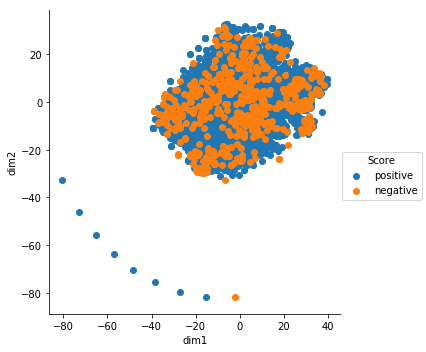

In [36]:
sns.FacetGrid(df,hue='Score',size=5).map(plt.scatter,'dim1','dim2').add_legend()

#### TFIDF after cleaning

In [11]:
tfidf_vec=TfidfVectorizer()
tfidf=tfidf_vec.fit_transform(final['cleaned_text'].values)
tfidf.shape

(364171, 71691)

* Observe the dimension change (before and after cleaning).

In [12]:
y=tfidf[:3500,:].toarray()

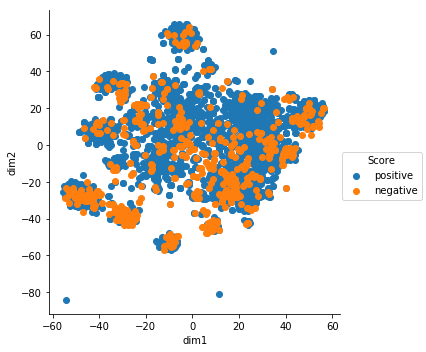

In [13]:
tsne=TSNE(n_components=2,perplexity=30).fit_transform(y)
df=pd.DataFrame(tsne,columns=('dim1','dim2'))
df=pd.concat([df,final['Score'].iloc[:3500]],axis=1)
sns.FacetGrid(df,hue='Score',size=5).map(plt.scatter,'dim1','dim2').add_legend()